# notMNIST
http://yaroslavvb.com/upload/notMNIST/

<img src="http://yaroslavvb.com/upload/notMNIST/nmn.png">

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
n_target = 10 # A to J
img_size = 28

### Loading Data

In [3]:
from PIL import Image
from skimage import io
import os

images = []
labels = []
path = '../Data/Kaggle/notMNIST_small'
for d in os.listdir(path):
    subpath = os.path.join(path, d)
    for i in os.listdir(subpath):
        try:
            image = io.imread(os.path.join(subpath, i), as_grey=True)
            if image.shape != (img_size, img_size):
                raise Exception('Unexpected image shape: %s' % str(image.shape))
            images.append(image)
            labels.append(d)
        except IOError as e:
            print(e, '- it\'s ok, skipping.')

cannot identify image file <_io.BufferedReader name='../Data/Kaggle/notMNIST_small\\A\\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png'> - it's ok, skipping.
cannot identify image file <_io.BufferedReader name='../Data/Kaggle/notMNIST_small\\F\\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png'> - it's ok, skipping.


In [4]:
X = np.array(images)
y = np.array(labels)

In [5]:
print(X.shape)
print(y.shape)

(18724, 28, 28)
(18724,)


### Loaking at the data

In [6]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=0)

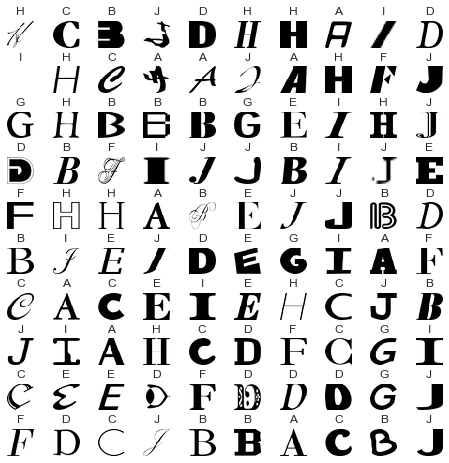

In [7]:
f, axes = plt.subplots(10, 10, figsize=(8, 8))
f.subplots_adjust(hspace=.7)
for index, image in enumerate(X[:100]):
    axes[int(index/10)][int(index%10)].imshow(image)
    axes[int(index/10)][int(index%10)].set_xticks(np.array([]))
    axes[int(index/10)][int(index%10)].set_yticks(np.array([]))
    axes[int(index/10)][int(index%10)].set_title(str(y[index]))

In [8]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{'A': 1872,
 'B': 1873,
 'C': 1873,
 'D': 1873,
 'E': 1873,
 'F': 1872,
 'G': 1872,
 'H': 1872,
 'I': 1872,
 'J': 1872}

### Data Preparation

In [9]:
from sklearn import preprocessing

In [10]:
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y) 

In [11]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14043, 28, 28)
(14043,)
(4681, 28, 28)
(4681,)


In [14]:
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype('float32').reshape(X_train.shape[0], img_size*img_size))
X_test  = scaler.transform(X_test.astype('float32').reshape(X_test.shape[0], img_size*img_size))

In [15]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [16]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
X_train = X_train.astype('float32').reshape(X_train.shape[0], img_size, img_size, 1)
X_test  = X_test.astype('float32').reshape(X_test.shape[0], img_size, img_size, 1)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14043, 28, 28, 1)
(14043, 10)
(4681, 28, 28, 1)
(4681, 10)


### Model

In [19]:
def plot_history(history, x, y):
    # list all data in history
    print(history.history.keys())
    fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    ax_acc.plot(history.history['acc'], label='train')
    ax_acc.plot(history.history['val_acc'], label='validation')
    ax_acc.set_xlabel('epoch')
    ax_acc.set_ylabel('accuracy')
    ax_acc.legend(loc='best')
    ax_acc.set_title('Accuracy')
    # summarize history for loss
    ax_loss.plot(history.history['loss'], label='trein')
    ax_loss.plot(history.history['val_loss'], label='validation')
    ax_loss.set_xlabel('epoch')
    ax_loss.set_ylabel('loss')
    ax_loss.legend(loc='best')
    ax_loss.set_title('Loss')

In [20]:
input_shape = (img_size, img_size, 1)

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

#### One Hidden Layer

In [22]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(Flatten())
model.add(Dense(n_target, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=0, validation_split=0.33)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


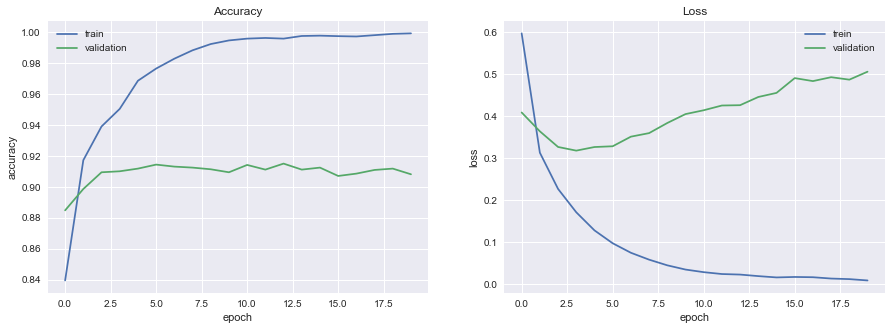

In [23]:
plot_history(history, 10, 5)

The model is doing pretty well on the training data, but it is not generalizing well. Let's try adding some batch normalization, max polling and dropout layers to reduce overfitting.

#### Dropout

In [24]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))    
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(n_target, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=0, validation_split=0.33)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


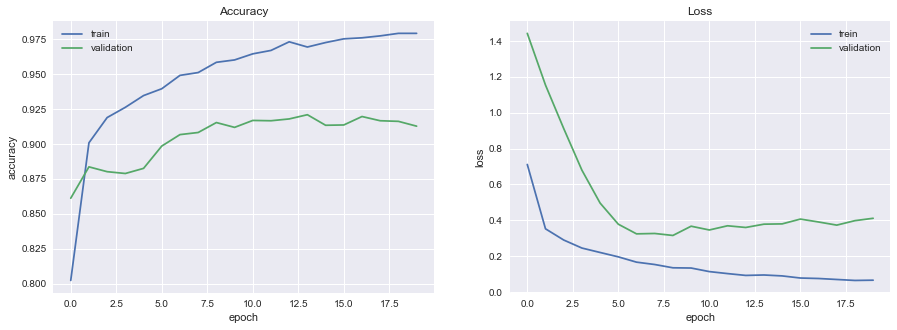

In [25]:
plot_history(history, 10, 5)

Not much improvement. Let's try adding more convolutional layers.

#### Two Conv2D Layers

In [26]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))    
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), input_shape=input_shape, padding='same'))    
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(n_target, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=0, validation_split=0.33)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


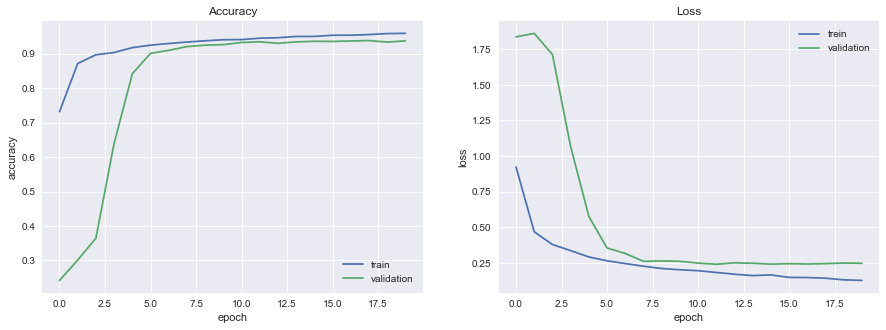

In [27]:
plot_history(history, 10, 5)

It seems that we achieve a little bit of improvement!

#### More layers

In [28]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', name='conv2d_1'))    
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), input_shape=input_shape, padding='same', name='conv2d_2'))    
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(n_target, activation='softmax', name='preds'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=0, validation_split=0.33)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


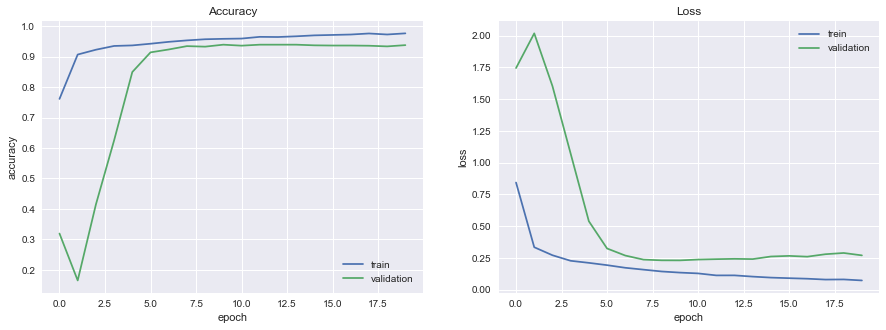

In [29]:
plot_history(history, 10, 5)

### Model Evaluation

In [30]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23255292801
Test accuracy: 0.944242683315


In [62]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

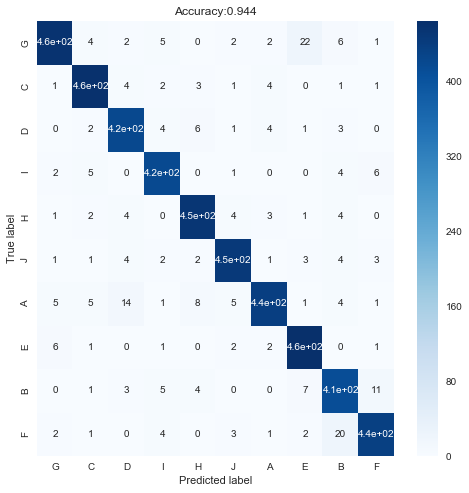

In [65]:
y_pred = model.model.predict(X_test)
cf = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))

df_cm = pd.DataFrame(cf, index=set(labels), columns=set(labels))

plt.figure(figsize = (8, 8))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [75]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

             precision    recall  f1-score   support

          0       0.91      0.96      0.94       477
          1       0.96      0.95      0.96       484
          2       0.95      0.93      0.94       454
          3       0.96      0.95      0.95       444
          4       0.96      0.95      0.96       477
          5       0.96      0.96      0.96       467
          6       0.91      0.96      0.94       456
          7       0.97      0.93      0.95       502
          8       0.93      0.90      0.91       459
          9       0.93      0.95      0.94       461

avg / total       0.94      0.94      0.94      4681



### Visualizing Hidden Layers

In [31]:
from vis.visualization import visualize_activation
from vis.utils import utils

from keras import activations

#### Dense Layer Activation

In [32]:
layer_idx = utils.find_layer_idx(model, 'preds')

model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

filter_idx = 0

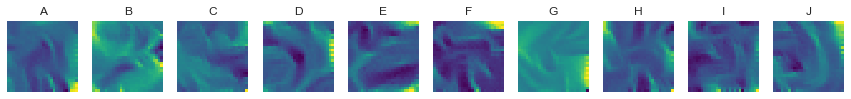

In [33]:
f, axes = plt.subplots(1, n_target, figsize=(20, 5))

vis_images = []
for output_idx in np.arange(n_target):
    # We will seed with optimized image this time.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    axes[output_idx].imshow(img[..., 0], cmap='viridis')
    axes[output_idx].set_xticks(np.array([]))
    axes[output_idx].set_yticks(np.array([]))
    axes[output_idx].set_title(str(unique[output_idx]))

#### Conv Filters

In [36]:
from vis.visualization import get_num_filters
from vis.input_modifiers import Jitter

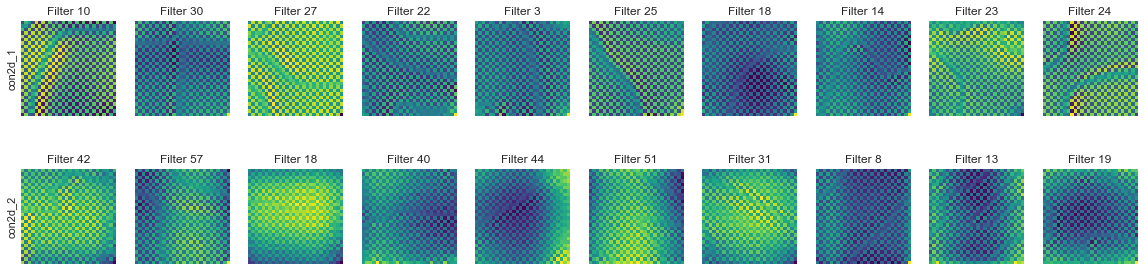

In [61]:
n_filters = 10
conv_layers = ['conv2d_1', 'conv2d_2']
f, axes = plt.subplots(len(conv_layers), n_filters, figsize=(20, 5))

selected_indices = []
for i, layer_name in enumerate(conv_layers):
    layer_idx = utils.find_layer_idx(model, layer_name)
    # Visualize random filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:n_filters]
    selected_indices.append(filters)
    # Generate input image for each filter.
    vis_images = []
    for j, idx in enumerate(filters):
        img = visualize_activation(model, layer_idx, filter_indices=idx, input_modifiers=[Jitter(0.05)])
        axes[i][j].imshow(img[..., 0], cmap='viridis')
        axes[i][j].set_xticks(np.array([]))
        axes[i][j].set_yticks(np.array([]))
        axes[i][j].set_title('Filter {}'.format(idx))

for i, row in enumerate(axes):
    for j, cell in enumerate(row):
        if j == 0:
            cell.set_ylabel(conv_layers[i])         